# Modelowanie tematyczne (ang. *topic modeling*)

W tej sekcji następuje główna część projektu, czyli zastosowanie algotymu modelowania tematycznego. 

Do analizy wybrany został algorytm **LDA** (*Latent Dirichlet Allocation*), czyli trójpoziomowy hierarchiczny model bayesowski, w którym każdy element zbioru jest modelowany jako skończona mieszanina obejmująca podstawowy zestaw tematów. Każdy temat jest z kolei modelowany jako nieskończona mieszanina na podstawie zbioru prawdopodobieństw tematycznych. W kontekście modelowania tekstu, prawdopodobieństwa tematu zapewniają jawną reprezentację dokumentu.

### Przygotowanie danych

Pierwszym krokiem jest przygotowanie tzw. **Bag of words**, czyli zbioru w formie listy słów i częstości ich wystąpień, a także **słownika**, czyli listy słów umiejscowionych odpowiednio do ich oryginalnych współrzędnych w początkowej ramce danych. Obie te zmienne muszą być w formie zmiennej *list*, ponieważ wymga tego uzywany w analizie algorytm pozyskany z biblioteki **gensim**.

In [1]:
import nltk
import pickle
import pandas as pd

In [2]:
word_count_top = pd.read_pickle('word_count_top.pkl')
df_clean = pd.read_pickle('df_clean.pkl')

Funkcja *text_to_dict* filtruje cały zbiór tekstu otrzymany po przetwarzaniu przez listę słów wybranych do analizy. W wyniku powstaje lista rekordów, na której słowa dopuszczone do analizy znajdują się na swoich oryginalnych pozycjach.

In [4]:
my_conditions = word_count_top.index.tolist()

def text_to_dict(text):
    #tokenizacja
    tokenized_words = nltk.word_tokenize(text)
    #uwarunek
    tokens_condit = [word for word in tokenized_words if word in my_conditions]
    return tokens_condit

to_dict = df_clean.text.apply(text_to_dict)

In [5]:
my_conditions[:10]

['field',
 'process',
 'farmer',
 'benefit',
 'crop',
 'family',
 'vitamin',
 'juice',
 'value',
 'nature']

In [6]:
to_dict[:10]

1     [farmer, cultivation, benefit, vitamin, farmer...
2                                                    []
3     [cultivation, interest, information, cultivation]
4                                            [interest]
5                            [consumption, consumption]
6                     [value, nutrition, benefit, body]
7                                     [nature, vitamin]
8                                 [field, nature, care]
9                             [nature, vitamin, nature]
10           [farmer, cultivation, support, production]
Name: text, dtype: object

In [7]:
import gensim

dictionary = gensim.corpora.Dictionary(to_dict)

In [8]:
bow_corpus = [dictionary.doc2bow(doc) for doc in to_dict]
bow_corpus[100]

[(10, 1)]

### Symulacja optymalnej liczby wątków LDA dla rzeczowników

Zanim zostanie wykonane modelowanie postanowiono dowiedzieć się jaka jest optymalna liczba tematów w modelu.

Do tego celu został skonstruowany poniższy algorytm.

W pierwszej kolejności definiowana jest funkcja *compute_coherence_values*, która ma za zadanie wykonać modelowanie za pomocą LDA dla liczby tematów mieszczącej się w przedziale od 2 do 40, a następnie dla każdego modelu obliczyć *coherence value*, czyli wskaźnik spójności modelu. Na bazie tego wskaźnika określona zostanie jakość modelu. Dokładna specyfikacja wskaźnika dostępna jest [pod tym adresem](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf).

Następnie za pomocą wykresu zostaje zobrazowana zależność między liczbą tematów, a spójnością modelu. Z analizy wielu wygenerowanych wykresów wynika, że modele z liczbą tematów wyższą niż 15 mają znacząco niższy wskaźnik spójności.

Po tej obserwacji liczba symulowanych tematów zostaje zawężona do przedziału między 2 a 15, a następnie funkcja *compute_coherence_values* jest wykonywana dziesięć razy, z czego każdy wynik optymalny jest zapisywany w tabeli. Na koniec wybierany jest najlepszy wynik z tabeli, który stanowi "najlepszy z najlepszych".

In [32]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=30, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [60]:
#wykonanie powyższej funkcji dla tematów od 2 do 40
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, 
                                                        start=2, limit=40, step=1)

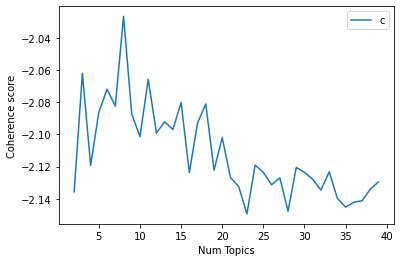

In [61]:
#Wizualizacja zgodności modeli z daną ilością tematów
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

limit=40; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#Wniosek: tendencja wskazuje, że wiecej niż 15 nie jest istotne

In [62]:
#Wypisanie każdego z 40 wyników
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of -2.1357
Num Topics = 3  has Coherence Value of -2.0619
Num Topics = 4  has Coherence Value of -2.1193
Num Topics = 5  has Coherence Value of -2.0861
Num Topics = 6  has Coherence Value of -2.0718
Num Topics = 7  has Coherence Value of -2.0824
Num Topics = 8  has Coherence Value of -2.0264
Num Topics = 9  has Coherence Value of -2.0873
Num Topics = 10  has Coherence Value of -2.1014
Num Topics = 11  has Coherence Value of -2.0656
Num Topics = 12  has Coherence Value of -2.0991
Num Topics = 13  has Coherence Value of -2.0921
Num Topics = 14  has Coherence Value of -2.0969
Num Topics = 15  has Coherence Value of -2.0801
Num Topics = 16  has Coherence Value of -2.1237
Num Topics = 17  has Coherence Value of -2.0929
Num Topics = 18  has Coherence Value of -2.081
Num Topics = 19  has Coherence Value of -2.1223
Num Topics = 20  has Coherence Value of -2.102
Num Topics = 21  has Coherence Value of -2.1269
Num Topics = 22  has Coherence Value of -2.1324
Nu

In [63]:
#Wyznaczenie najlepszego wyniku z powyższych 40
optimal_t = [m for m, cv in zip(x, coherence_values) if cv == max(coherence_values)]
optimal_n = [cv for m, cv in zip(x, coherence_values) if cv == max(coherence_values)]
print("Optimal Num Topics =", optimal_t, " has Coherence Value of", optimal_n)

Optimal Num Topics = [8]  has Coherence Value of [-2.026405512346171]


In [64]:
opt_top = pd.DataFrame(columns=['Num_Topics', 'Coherence_Value'])

In [65]:
#Pętla wykonująca 10 razy ewaluacje 12 modeli LDA i wybór optimum, zapisująca 10 optymalnych rozwiązań do ramki danych

for i in range(10):
    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, 
                                                        start=2, limit=12, step=1)
    optimal_t = [m for m, cv in zip(x, coherence_values) if cv == max(coherence_values)]
    optimal_n = [cv for m, cv in zip(x, coherence_values) if cv == max(coherence_values)]
    opt_top.loc[i] = optimal_t + optimal_n

In [72]:
opt_top.head(10)

,Num_Topics,Coherence_Value
0,11.0,-2.053947
1,5.0,-2.038382
2,2.0,-2.015553
3,8.0,-2.028757
4,5.0,-2.048322
5,3.0,-2.050231
6,6.0,-2.051097
7,3.0,-2.052287
8,3.0,-2.048560
9,5.0,-1.993876


In [68]:
#Wyświetlenie najlepszego wyniku z 10 najlepszych wyników - ostateczny wynik
print(opt_top.loc[opt_top['Coherence_Value'] == opt_top['Coherence_Value'].max()])

   Num_Topics  Coherence_Value
9         5.0        -1.993876


Z powyższej symulacji wynikło, że optymalną liczbą tematów w modelu jest 5.

### Obliczanie modelu

Po przygotowaniu danych w odpowiedniej formie wykonany został algorytm LDA w dwóch wariantach.
1. W pierwszym wariancie liczba tematów do wygenerowania została ustalona arbitralnie, na podstawie teorii marketingowej.
2. W drugim wariancie liczba tematów jest optimum obliczonym przez algorytm symulacyjny. 

##### Obliczanie modelu dla 2 wątków

In [32]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=2, id2word=dictionary, passes=300, workers=4)

for idx, topic in lda_model.print_topics(-1,15):
    print('Topic: {} \nWords: {}\n'.format(idx, topic))

Topic: 0 
Words: 0.136*"meal" + 0.119*"benefit" + 0.100*"vitamin" + 0.091*"family" + 0.086*"juice" + 0.082*"fresh" + 0.074*"child" + 0.072*"tasty" + 0.064*"positive" + 0.059*"value" + 0.058*"diet" + 0.057*"interest" + 0.000*"natural" + 0.000*"process" + 0.000*"field" + 0.000*"farmer" + 0.000*"nature"

Topic: 1 
Words: 0.150*"field" + 0.143*"grow" + 0.142*"farmer" + 0.130*"process" + 0.099*"crop" + 0.085*"polish" + 0.081*"natural" + 0.078*"nature" + 0.065*"cultivation" + 0.019*"value" + 0.004*"vitamin" + 0.000*"fresh" + 0.000*"benefit" + 0.000*"diet" + 0.000*"family" + 0.000*"juice" + 0.000*"tasty"



In [9]:
#Zapisywanie ciekawszych modeli
from gensim.test.utils import datapath

#lda_model.save('model\\lda_all_1.1')

##### Obliczanie modelu dla symulowanej liczby wątków

In [5]:
lda_model_sim = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=300, workers=4)

for idx, topic in lda_model_sim.print_topics(-1,15):
    print('Topic: {} \nWords: {}\n'.format(idx, topic))

Topic: 0 
Words: 0.291*"family" + 0.271*"vitamin" + 0.237*"child" + 0.139*"positive" + 0.056*"fresh" + 0.000*"juice" + 0.000*"diet" + 0.000*"field" + 0.000*"natural" + 0.000*"grow"

Topic: 1 
Words: 0.470*"meal" + 0.249*"tasty" + 0.223*"fresh" + 0.052*"diet" + 0.000*"juice" + 0.000*"vitamin" + 0.000*"process" + 0.000*"interest" + 0.000*"grow" + 0.000*"farmer"

Topic: 2 
Words: 0.431*"benefit" + 0.280*"value" + 0.208*"interest" + 0.075*"positive" + 0.000*"diet" + 0.000*"cultivation" + 0.000*"grow" + 0.000*"vitamin" + 0.000*"process" + 0.000*"nature"

Topic: 3 
Words: 0.177*"juice" + 0.175*"process" + 0.157*"natural" + 0.154*"grow" + 0.115*"nature" + 0.090*"diet" + 0.088*"cultivation" + 0.041*"vitamin" + 0.000*"fresh" + 0.000*"crop"

Topic: 4 
Words: 0.242*"field" + 0.230*"farmer" + 0.160*"crop" + 0.137*"polish" + 0.102*"grow" + 0.064*"process" + 0.032*"cultivation" + 0.030*"nature" + 0.000*"vitamin" + 0.000*"fresh"



In [9]:
#Zapisywanie ciekawszych modeli
from gensim.test.utils import datapath

#lda_model.save('model\\lda_all_2.1')

Wizualizacja wyników analizy znajduje się w pliku [*results_visualisation.ipynb*](4_results_visualisation.ipynb).